This system uses the Tensorflow guide as a basic framework with modification being made to it as necessary. Guide and code available at https://www.tensorflow.org/text/tutorials/text_generation#vectorize_the_text

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/spanish.txt'

Mounted at /content/drive


In [ ]:
# Get desired word from user
desired_word = input('Enter the desired word: ')

# Read the text
text = open(path, 'rb').read().decode(encoding='utf-8')

# Remove any blank space notation
text = text.replace("\n", " ")
text = text.replace("\r", " ")

# Search for any sentences containing the input word
new_text = re.findall(r"([^.!?]*?" + re.escape(desired_word) + r"[^.!?]*[.!?])", text)

# Rejoin list arrays into string
new_text = "".join(str(element) for element in new_text)

Enter the desired word: donde


In [ ]:
# Create a set that contains every word and punctuation in the text file
vocab = sorted(set(new_text))

In [ ]:
# Converts each character into a vector id
char_to_id = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
# Converts each vector id back into a character
id_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_id.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(id_to_char(ids), axis=-1)

In [ ]:
# Takes each character from the filtered text file and turns them into a vector representation
all_ids = char_to_id(tf.strings.unicode_split(new_text, 'UTF-8'))

In [ ]:
# Take a vector and turn it into a stream of charcaters
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 100

# Use "batch()" to create sequences of characters easily and to keep it as a Tensor
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
# This method allows for an input to be turned into a target for the model to train on
# An exampl of this working would be the input "Hell", the output would be "ello"
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
# Creating a detaset that contains both the input and the target for the model to train on
dataset = sequences.map(split_input_target)

In [ ]:
# Batch size, this was a value that still improved speed but allowed for smaller datasets
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

# Shuffling dataset
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(char_to_id.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
# Creating the model
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    # An embedding layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # GRU layer
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    # Dense layer
    self.dense = tf.keras.layers.Dense(vocab_size)

    # Originally I wanted to use 2 GRU layers but after some experimentation I was getting outputs like:
    # "Asó ho ho es so ha ho y hara ho En har, ecande jes e hacó hundo hindo" which do not make sense so I
    # swapped back to using 1

  def call(self, inputs, states=None, return_state=False, training=False):
    # The input is passed through the embedding layer
    x = inputs
    x = self.embedding(x, training=training)
    # Running the input through the GRU layer
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    # Returning an output through the dense layer
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
# Declaring the model
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
# Building the model by running a batch of data on it
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  13312     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  53300     
                                                                 
Total params: 4004916 (15.28 MB)
Trainable params: 4004916 (15.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Adding the Categorical Crossentropy loss function
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
# 150 epochs is a good number as after this many epochs the accuracy doesnt increase very much and we dont want to overfit
EPOCHS = 100

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/100
3/3 [==============================] - 3s 167ms/step - loss: 3.9032 - accuracy: 0.1313
Epoch 2/100
3/3 [==============================] - 0s 116ms/step - loss: 4.7077 - accuracy: 0.1903
Epoch 3/100
3/3 [==============================] - 0s 114ms/step - loss: 3.6936 - accuracy: 0.2207
Epoch 4/100
3/3 [==============================] - 0s 103ms/step - loss: 3.7246 - accuracy: 0.1950
Epoch 5/100
3/3 [==============================] - 0s 137ms/step - loss: 3.6753 - accuracy: 0.1520
Epoch 6/100
3/3 [==============================] - 0s 84ms/step - loss: 3.5484 - accuracy: 0.1340
Epoch 7/100
3/3 [==============================] - 0s 81ms/step - loss: 3.2863 - accuracy: 0.1200
Epoch 8/100
3/3 [==============================] - 0s 86ms/step - loss: 3.1581 - accuracy: 0.1220
Epoch 9/100
3/3 [==============================] - 0s 74ms/step - loss: 2.9637 - accuracy: 0.2123
Epoch 10/100
3/3 [==============================] - 0s 70ms/step - loss: 2.9663 - accuracy: 0.1943
Epoch 11/100
3

In [ ]:
# Drawing a graph to check the accuracy of the model
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

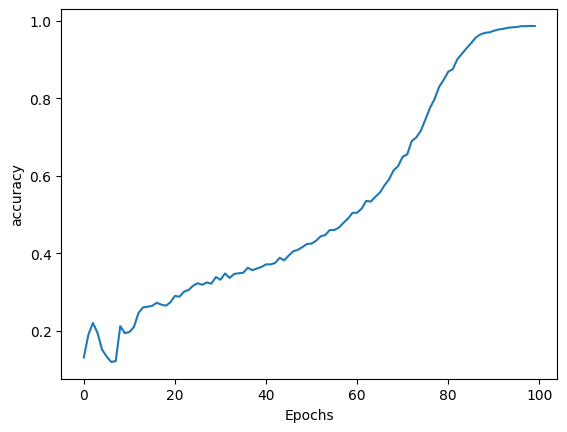

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
# This code defines the model that creates a one step prediction (predicts the next character)
# Code taken from https://www.tensorflow.org/text/tutorials/text_generation#vectorize_the_text
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, id_to_char, char_to_id)

In [ ]:
# Declaring states as a variable, putting "None" directly into the call doesnt work
states = None
# Using desired_word as the seed
next_char = tf.constant([desired_word])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states)
  result.append(next_char)

result = tf.strings.join(result)
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

donde  encuentran mancida na ie guerra de liemba da givir en el mundo donde todos los hombres eran iguales, de echuente, que yo haré donde me acueste. La madre nonde  esta celeba, os dosde se se cloria, de vivir en el mundo donde todos los hombres eran iguales.    --Buenos días, señor--contento y dis un so nochie parado, Tamburí se propuso quemar los endiablados zapatos  y los llevóa do dicra ce ll varcha  ententan con do que fararos míjos  que yo haré zucandos  del azúcar.    El lugareño y su mujer se sentano fujo  que ver tantos primores y  maravillas.    Le do hey emandimiento,  Dabarías y condostedos me sus habias donde se había de las ellía, y así no podía desecha  títod,  quitándose el sombrero--quisie a lá teronzo  e tadal cons deros paracoí de nde ertaban lo   cábalos  el suelPada an las meldo donde te se ha la mey azúcar cubernos buenos,  mucho azúja. -Sarende suy mondestó re  elo cule carida emtron las mujoo--so dijo con  ésfasiendes marcha igual, de madre nel azúcar.    El l